# Torch implementation

In [289]:
import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from os import path
from abc import ABC
from gpytorch.constraints import Positive, Interval

from collections.abc import Iterable
from abc import abstractmethod
from typing import List
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torch.distributions import MultivariateNormal
from torch.nn import Module
from time import time
from pathlib import Path



f64 = np.float64

In [290]:
from torch.utils.data import Dataset
class LFMDataset(Dataset):

    def __getitem__(self, index):
        return self.data[index]

    @property
    def num_outputs(self):
        """The number of LFM outputs."""
        return self._num_outputs

    @num_outputs.setter
    def num_outputs(self, value):
        self._num_outputs = value

    @property
    def data(self):
        """
        List of data points, each a tuple(a, b).
        For time-series, a and b are 1-D.
        For spatiotemporal series, a is (2, T) corresponding to a row for time and space, and b is 1-D.
        """
        return self._data

    @data.setter
    def data(self, value):
        self._data = value

    def __len__(self):
        return len(self.data)

In [291]:
class TranscriptomicTimeSeries(LFMDataset, ABC):
    def __init__(self):
        self._m_observed = None
        self._t_observed = None

    @property
    def t_observed(self):
        return self._t_observed

    @t_observed.setter
    def t_observed(self, value):
        self._t_observed = value

    @property
    def m_observed(self):
        """m_observed has shape (replicates, genes, times)"""
        return self._m_observed

    @m_observed.setter
    def m_observed(self, value):
        self._m_observed = value

In [292]:
class P53Data(TranscriptomicTimeSeries):
    def __init__(self, replicate=None, data_dir='../data/'):
        super().__init__()
        m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma(data_dir)

        m_df, m_observed = m_observed  # (replicates, genes, times)
        self.gene_names = m_df.index
        num_times = m_observed.shape[2]
        num_genes = m_observed.shape[1]
        num_replicates = m_observed.shape[0]
        self.num_outputs = num_genes

        # f_df, f_observed = f_observed
        m_observed = torch.tensor(m_observed)
        self.t_observed = torch.linspace(f64(0), f64(12), 7)
        self.m_observed = m_observed
        self.f_observed = torch.tensor([0.7116,0.7008,1.5933,0.7507,0.2346,0.3617,0.0673]).view(1, 1, 7)
        self.f_observed = torch.tensor([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131]).view(1, 1, 7)

        self.params = torch.tensor([
            0.06374478, 0.01870999, 0.0182909,  0.0223461,  0.08485352, 0.9133557, 0.9743523,
            0.9850107,  1., 0.974792,   0.27596828, 0.367931, 0.35159853, 0.79999995, 0.34772962
        ]).view(3, 5)
        if replicate is None:
            self.variance = np.array([f64(σ2_m_pre)[r, i] for r in range(num_replicates) for i in range(num_genes)])
            self.data = [(self.t_observed, m_observed[r, i]) for r in range(num_replicates) for i in range(num_genes)]
        else:
            self.m_observed = self.m_observed[replicate:replicate+1]
            self.f_observed = self.f_observed[0:1]
            self.variance = np.array([f64(σ2_m_pre)[replicate, i] for i in range(num_genes)])
            self.data = [(self.t_observed, m_observed[replicate, i]) for i in range(num_genes)]

    @staticmethod
    def params_ground_truth():
        B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
        D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
        S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
        return B_exact, S_exact, D_exact


In [293]:
def load_barenco_puma(dir_path):
    mmgmos_processed = True
    if mmgmos_processed:
        with open(path.join(dir_path, 'barencoPUMA_exprs.csv'), 'r') as f:
            df = pd.read_csv(f, index_col=0)
        with open(path.join(dir_path, 'barencoPUMA_se.csv'), 'r') as f:
            dfe = pd.read_csv(f, index_col=0)
        columns = [f'cARP{r}-{t}hrs.CEL' for r in range(1, 4) for t in np.arange(7)*2]
    else:
        with open(path.join(dir_path, 'barenco_processed.tsv'), 'r') as f:
            df = pd.read_csv(f, delimiter='\t', index_col=0)

        columns = [f'H_ARP1-{t}h.3' for t in np.arange(7)*2]

    known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at', '209295_at', '211300_s_at']
    genes = df[df.index.isin(known_target_genes)][columns]
    genes_se = dfe[dfe.index.isin(known_target_genes)][columns]

    assert df[df.duplicated()].size == 0

    index = {
        '203409_at': 'DDB2',
        '202284_s_at': 'p21',
        '218346_s_at': 'SESN1',
        '205780_at': 'BIK',
        '209295_at': 'DR5',
        '211300_s_at': 'p53'
    }
    genes.rename(index=index, inplace=True)
    genes_se.rename(index=index, inplace=True)

    # Reorder genes
    genes_df = genes.reindex(['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53'])
    genes_se = genes_se.reindex(['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53'])

    tfs_df = genes_df.iloc[-1:]
    genes_df = genes_df.iloc[:-1]
    genes = genes_df.values
    tfs = tfs_df.values

    tf_var = genes_se.iloc[-1:].values**2
    gene_var = genes_se.iloc[:-1].values**2

    tfs_full = np.exp(tfs + tf_var/2)
    genes_full = np.exp(genes+gene_var/2)

    tf_var_full = (np.exp(tf_var)-1)*np.exp(2*tfs + tf_var)
    gene_var_full = (np.exp(gene_var)-1)*np.exp(2*genes + gene_var) # This mistake is in Lawrence et al.

    tf_scale = np.sqrt(np.var(tfs_full[:, :7], ddof=1))
    tf_scale = np.c_[[tf_scale for _ in range(7*3)]].T
    tfs = np.float64(tfs_full / tf_scale).reshape((3, 1, 7))
    tf_var = (tf_var_full / tf_scale**2).reshape((3, 1, 7))

    gene_scale = np.sqrt(np.var(genes_full[:,:7], axis=1, ddof=1))
    gene_scale = np.c_[[gene_scale for _ in range(7*3)]].T
    genes = np.float64(genes_full / gene_scale).reshape((5, 3, 7)).swapaxes(0, 1)
    gene_var = np.float64(gene_var_full / gene_scale**2).reshape((5, 3, 7)).swapaxes(0, 1)

    return (genes_df, genes), (tfs_df, np.float64(tfs)), gene_var, tf_var, np.arange(7)*2   

In [294]:
import os
def load_barenco_data(dir_path):
    """
    Load gene expressions and associated uncertainties from Barenco et al. (2006) microarray measureents return log-normalised data.

    Parameters
    ----------
    dir_path : str
        Path to directory containing the data files.

    Returns
    -------
    dict
        Dictionary containing the following keys:
        - gene_names: list of gene names
        - gene_expressions: array of shape (3, 5, 7) containing gene expressions
        - gene_variances: array of shape (3, 5, 7) containing gene expression variances
        - p53_expressions: array of shape (3, 1, 7) containing p53 expressions
        - p53_variances: array of shape (3, 1, 7) containing p53 expression variances
    """

    # Load data from .csv files
    with open(os.path.join(dir_path, "barencoPUMA_exprs.csv"), "r") as f:
        gene_expressions = pd.read_csv(f, index_col=0)
    with open(os.path.join(dir_path, "barencoPUMA_se.csv"), "r") as f:
        gene_expressions_se = pd.read_csv(f, index_col=0)

    columns = [f"cARP{r}-{t}hrs.CEL" for r in range(1, 4) for t in np.arange(7) * 2]

    # Known genes from Barenco paper
    known_target_genes = [
        "203409_at",
        "202284_s_at",
        "218346_s_at",
        "205780_at",
        "209295_at",
        "211300_s_at",
    ]

    genes = gene_expressions[gene_expressions.index.isin(known_target_genes)][columns]
    genes_se = gene_expressions_se[gene_expressions_se.index.isin(known_target_genes)][
        columns
    ]

    index = {
        "203409_at": "DDB2",
        "202284_s_at": "p21",
        "218346_s_at": "SESN1",
        "205780_at": "BIK",
        "209295_at": "DR5",
        "211300_s_at": "p53",
    }

    genes.rename(index=index, inplace=True)
    genes_se.rename(index=index, inplace=True)

    # Reorder genes
    genes_df = genes.reindex(["DDB2", "BIK", "DR5", "p21", "SESN1", "p53"])
    genes_se = genes_se.reindex(["DDB2", "BIK", "DR5", "p21", "SESN1", "p53"])

    p53_df = genes_df.iloc[-1:]
    genes_df = genes_df.iloc[:-1]
    genes = genes_df.values
    p53 = p53_df.values

    # Get variance for each gene expression value
    p53_var = genes_se.iloc[-1:].values ** 2
    genes_var = genes_se.iloc[:-1].values ** 2

    # Log-normal transform
    p53_full = np.exp(p53 + p53_var / 2)
    genes_full = np.exp(genes + genes_var / 2)

    # Calculate full variance in transformed space
    p53_var_full = (np.exp(p53_var) - 1) * np.exp(2 * p53 + p53_var)
    genes_var_full = (np.exp(genes_var) - 1) * np.exp(2 * genes + genes_var)

    # Normalise and rescale the data
    p53_scale = np.sqrt(np.var(p53_full[:, :7], ddof=1))
    p53_scale = np.c_[[p53_scale for _ in range(7 * 3)]].T

    p53_expressions = np.float64(p53_full / p53_scale).reshape((3, 1, 7))
    p53_variances = np.float64(p53_var_full / p53_scale**2).reshape((3, 1, 7))

    genes_scale = np.sqrt(np.var(genes_full[:, :7], axis=1, ddof=1))
    genes_scale = np.c_[[genes_scale for _ in range(7 * 3)]].T

    genes_expressions = (
        np.float64(genes_full / genes_scale).reshape((5, 3, 7)).swapaxes(0, 1)
    )
    genes_variances = (
        np.float64(genes_var_full / genes_scale**2).reshape((5, 3, 7)).swapaxes(0, 1)
    )

    # Get gene names
    gene_names = list(genes_df.index)

    return {
        "gene_names": gene_names,
        "gene_expressions": genes_expressions,
        "gene_variances": genes_variances,
        "p53_expressions": p53_expressions,
        "p53_variances": p53_variances,
    }


In [295]:
torch.set_default_dtype(torch.float64)

## Re-implement data loading
class PyTorchDataset(Dataset):
    def __init__(self, replicate=None, data_dir='../data/'):
        gene_data = load_barenco_data(data_dir)
        
        self.gene_names = gene_data["gene_names"]
        self.gene_expressions = gene_data["gene_expressions"]
        self.gene_variances_raw = gene_data["gene_variances"]
        self.num_genes = len(self.gene_names)
        self.timepoints = torch.linspace(0, 12, 7)

        # Latent force reported in Barenco paper
        f_observed = torch.tensor([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131]).view(1, 1, 7)
        self.f_observed = f_observed

        # Handle gene expression and variances based on 'replicate' number
        if replicate is None:
            # Use all replicates (triplicates) of the data
            # Iterate over replicates first, then genes:
            # Gene 1, rep 1, ..., gene 5, rep 1, gene 1, rep 2, ..., gene 5, rep 3
            self.data = [
                (self.timepoints, self.gene_expressions[r, i])
                for r in range(self.gene_expressions.shape[0])
                for i in range(self.num_genes)
            ]
            self.gene_variances = np.array(
                [
                    self.gene_variances_raw[r, i]
                    for r in range(self.gene_expressions.shape[0])
                    for i in range(self.num_genes)
                ]
            )

        else:
            self.gene_expressions = np.array(
                self.gene_expressions[replicate : replicate + 1]
            )
            self.data = [
                (self.timepoints, self.gene_expressions[0, i])
                for i in range(self.num_genes)
            ]
            self.gene_variances = np.array(
                self.gene_variances_raw[replicate : replicate + 1]
            )

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def params_ground_truth():
        B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
        D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
        S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
        return B_exact, S_exact, D_exact

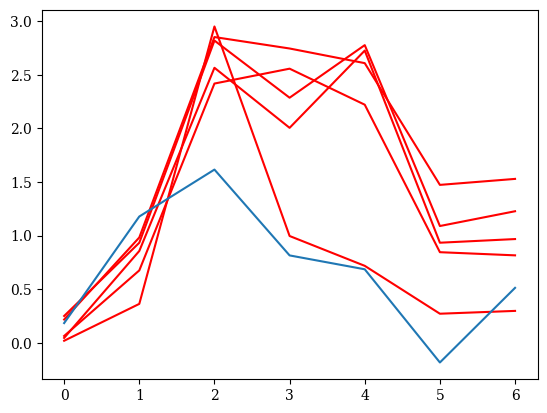

In [296]:
dataset = P53Data(replicate=0, data_dir='../data/')
#dataset = PyTorchDataset(replicate=0, data_dir='../data/')
ground_truth = P53Data.params_ground_truth()


for i in range(5):
    plt.plot(dataset.m_observed[0, i], color='red')
plt.plot(dataset.f_observed[0, 0])
plt.show()

### Kernel definition

In [297]:
PI = torch.tensor(np.pi, requires_grad=False)


class SIMKernel(gpytorch.kernels.Kernel):
    """
    Simple Input Module Motif Kernel
    This kernel is the multi-output cross-kernel for linear response to single transcription factor.
    In other words, it constructs a JTxJT matrix where J is num genes and T is num timepoints.
    SIM: Single Input Module motif
    """

    is_stationary = True

    def __init__(self, num_genes, variance, dtype=torch.float32, **kwargs):
        super().__init__(**kwargs)
        self.num_genes = num_genes
        self.pos_constraint = Positive()
        self.lengthscale_constraint = Interval(0.5, 3.5)

        self.register_parameter(
            name='raw_lengthscale', parameter=torch.nn.Parameter(
                self.lengthscale_constraint.inverse_transform(2.5 * torch.ones(1, 1, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_decay', parameter=torch.nn.Parameter(
                self.pos_constraint.inverse_transform(0.4 * torch.ones(self.num_genes, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_sensitivity', parameter=torch.nn.Parameter(
                self.pos_constraint.inverse_transform(1 * torch.ones(self.num_genes, dtype=dtype)))
        )


        # register the constraints
        self.register_constraint("raw_lengthscale", self.lengthscale_constraint)
        self.register_constraint("raw_sensitivity", Positive())
        self.register_constraint("raw_decay", Positive())

        self.variance = torch.diag(variance)

    @property
    def lengthscale(self):
        return self.lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        self.initialize(raw_lengthscale=self.lengthscale_constraint.inverse_transform(value))

    @property
    def decay(self):
        return self.pos_constraint.transform(self.raw_decay)

    @decay.setter
    def decay(self, value):
        self.initialize(raw_decay=self.pos_constraint.inverse_transform(value))

    @property
    def sensitivity(self):
        return self.pos_constraint.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.initialize(raw_sensitivity=self.pos_constraint.inverse_transform(value))

    @property
    def noise(self):
        return self.pos_constraint.transform(self.raw_noise)

    def plot_cov(self, x1, x2):
        from matplotlib import pyplot as plt
        Kxx = self(x1, x2)
        plt.figure()
        plt.imshow(Kxx.detach().evaluate().detach())
        plt.colorbar()
        return Kxx

    def forward(self, t1, t2, **params):
        """
        This calculates Kxx (not cross-covariance)
        t1, t2 are blocked timepoint vectors
        Parameters:
           x1 shape (num_genes*num_times)
        """
        vert_block_size = int(t1.shape[0] / self.num_genes)
        hori_block_size = int(t2.shape[0] / self.num_genes)
        t1_block, t2_block = t1[:vert_block_size], t2[:hori_block_size]
        shape = [vert_block_size * self.num_genes, hori_block_size * self.num_genes]
        K_xx = torch.zeros(shape, dtype=torch.float64)
        for j in range(self.num_genes):
            for k in range(self.num_genes):
                kxx = self.k_xx(j, k, t1_block, t2_block)
                K_xx[j * vert_block_size:(j + 1) * vert_block_size,
                     k * hori_block_size:(k + 1) * hori_block_size] = kxx

        if hori_block_size == vert_block_size:
            # noise = self.noise.view(-1, 1).repeat(1, hori_block_size).view(-1)
            # noise = torch.diag(noise)
            jitter = 1e-4 * torch.eye(K_xx.shape[0], dtype=torch.float64)
            K_xx += jitter
            if K_xx.shape[0] == self.variance.shape[0]:
                K_xx += self.variance
        return K_xx
    

    def k_xx(self, j, k, t1_block, t2_block):
        """
        k_xx(t, t')
        t2 = t'
        Parameters:
            t1_block: tensor shape (T1,)
            t2_block: tensor shape (T2,)
        """
        t1_block = t1_block.view(-1, 1)
        t2_block = t2_block.view(1, -1)




        mult = self.sensitivity[j] * self.sensitivity[k] * self.lengthscale * 0.5 * torch.sqrt(PI)
        second_term = (self.h(k, j, t2_block, t1_block) + self.h(j, k, t1_block, t2_block))

        k_xx = mult * second_term
        #debug
        """
        print(second_term.shape)
        print(f'mult {mult}, shape: {mult.shape}')
        print(f'second term {second_term}, shape: {second_term.shape}')

        print(f'kxx shape {k_xx.shape}')

        print(f'j index {j}, k index {k}')
        print(f'time 1 {t1_block}, time 2 {t2_block}')
        print(f'sj {self.sensitivity[j]}, sk {self.sensitivity[k]}, l {self.lengthscale}, dj {self.decay[j]}, dk {self.decay[k]}')
        print(f'all sensitivity {self.sensitivity}')
        print(f'all decay {self.decay}')
        """
        return k_xx

    def h(self, k, j, t2, t1):
        l = self.lengthscale
        t_dist = t2 - t1
        multiplier = torch.exp(self.gamma(k) ** 2) / (self.decay[j] + self.decay[k])  # (1, 1)
        first_erf_term = torch.erf(t_dist / l - self.gamma(k)) + torch.erf(t1 / l + self.gamma(k))  # (T,T)
        second_erf_term = torch.erf(t2 / l - self.gamma(k)) + torch.erf(self.gamma(k))
        return multiplier * (torch.multiply(torch.exp(-self.decay[k] * t_dist), first_erf_term) - \
                             torch.multiply(torch.exp(-self.decay[k] * t2 - self.decay[j] * t1), second_erf_term))




    def gamma(self, k):
        return self.decay[k] * self.lengthscale / 2

    def K_xf(self, x, f):
        """
        K_xf
        Cross-covariance. Not optimised (not in marginal likelihood).
        Parameters:
            x: tensor (JT, JT) the blocked observation vector
            f: tensor (T*) the non-blocked f prediction timepoint vector
        """
        shape = [x.shape[0], f.shape[0]]
        K_xf = torch.zeros(shape, dtype=torch.float32)
        self.block_size = int(x.shape[0] / self.num_genes)  # 7
        t1_block, t2_block = x[:self.block_size].view(-1, 1), f.view(1, -1)
        for j in range(self.num_genes):
            kxf = self.k_xf(j, t1_block, t2_block)
            K_xf[j * self.block_size:(j + 1) * self.block_size] = kxf
        
        # save k_xf as global variable
        self.k_xf = K_xf

        return K_xf

    #def k_xf(self, j, x, t_f):
        l = self.lengthscale
        t_dist = x - t_f
        erf_term = torch.erf(t_dist / l - self.gamma(j)) + torch.erf(t_f / l + self.gamma(j))

        return self.sensitivity[j] * l * 0.5 * torch.sqrt(PI) * torch.exp(self.gamma(j) ** 2) * torch.exp(
            -self.decay[j] * t_dist) * erf_term

    def k_xf(self, j, x, t_f):
        print('new kxf')
        l = self.lengthscale
        t_dist = x - t_f
        
        first_term = 0.5 * l * torch.sqrt(PI) * self.sensitivity[j]
        first_expon_term = torch.exp(self.gamma(j) ** 2)
        second_expon_term = torch.exp(-self.decay[j] * t_dist)
        erf_terms = torch.erf((t_dist / l) - self.gamma(j)) + torch.erf(t_f/l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms

        return kxf  

    def K_ff(self, x1, x2):
        """Returns the RBF kernel between latent TF"""
        x1 = x1.view(-1)
        x2 = x2.view(-1)
        sq_dist = torch.square(x1.view(-1, 1)-x2)
        sq_dist = torch.div(sq_dist, 2*self.lengthscale.view((-1, 1)))
        K = torch.exp(-sq_dist)
        if K.shape[0] == K.shape[1]:
            jitter = 1e-3 * torch.eye(x1.shape[0])
            K += jitter
        return K

### Mean function definition

In [298]:
class SIMMean(gpytorch.means.Mean):

    def __init__(self, covar_module, num_genes, initial_basal):
        super().__init__()
        self.covar_module = covar_module
        self.pos_contraint = Positive()
        self.covar_module = covar_module
        self.num_genes = num_genes

        self.register_parameter(
            name='raw_basal', parameter=torch.nn.Parameter(
                self.pos_contraint.inverse_transform(0.05 * torch.ones(self.num_genes)))
        )
        self.register_constraint("raw_basal", self.pos_contraint)

        # self.basal = initial_basal

    @property
    def basal(self):
        return self.pos_contraint.transform(self.raw_basal)

    @basal.setter
    def basal(self, value):
        self.initialize(raw_basal=self.pos_contraint.inverse_transform(value))

    def forward(self, x):
        # Debug print statement
        #print(f"Mean forward x shape: {x.shape}")
        #print(f"Mean forward x: {x}")
        block_size = int(x.shape[0] / self.num_genes)
        #print(f"Basal shape: {self.basal.shape}")
        #print(self.basal)
        #print(f"Decay shape: {self.covar_module.decay.shape}")
        #print(self.covar_module.decay)
        m = (self.basal / self.covar_module.decay).view(-1, 1)
        #print(m.shape)
        #print(m)
        m = m.repeat(1, block_size).view(-1)
        #print(m.shape)
        #print(m)
        return m

### Model definition

In [302]:
class ExactLFM(gpytorch.models.ExactGP):
    """
    An implementation of the single input motif from Lawrence et al., 2006.
    """
    def __init__(self, dataset: LFMDataset, variance):
        train_t, train_y = flatten_dataset(dataset)
        super().__init__(train_t, train_y, likelihood=gpytorch.likelihoods.GaussianLikelihood())

        self.num_outputs = dataset.num_outputs
        self.train_t = train_t.view(-1, 1)
        self.train_y = train_y.view(-1, 1)
        self.covar_module = SIMKernel(self.num_outputs, torch.tensor(variance, requires_grad=False))
        initial_basal = torch.mean(train_y.view(self.num_outputs, -1), dim=1) * self.covar_module.decay
        self.mean_module = SIMMean(self.covar_module, self.num_outputs, initial_basal)

    @property
    def decay_rate(self):
        return self.covar_module.decay

    @decay_rate.setter
    def decay_rate(self, val):
        self.covar_module.decay = val

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def predict_m(self, pred_t, jitter=1e-5) -> torch.distributions.MultivariateNormal:
        """
        Predict outputs of the LFM
        :param pred_t: prediction times
        :param jitter:
        :return:
        """
        Kxx = self.covar_module(self.train_t, self.train_t)
        K_inv = torch.inverse(Kxx.evaluate())
        pred_t_blocked = pred_t.repeat(self.num_outputs)
        K_xxstar = self.covar_module(self.train_t, pred_t_blocked).evaluate()
        K_xstarx = torch.transpose(K_xxstar, 0, 1).type(torch.float64)
        K_xstarxK_inv = torch.matmul(K_xstarx, K_inv)
        KxstarxKinvY = torch.matmul(K_xstarxK_inv, self.train_y)
        mean = KxstarxKinvY.view(self.num_outputs, pred_t.shape[0])

        K_xstarxstar = self.covar_module(pred_t_blocked, pred_t_blocked).evaluate()
        var = K_xstarxstar - torch.matmul(K_xstarxK_inv, torch.transpose(K_xstarx, 0, 1))
        var = torch.diagonal(var, dim1=0, dim2=1).view(self.num_outputs, pred_t.shape[0])
        mean = mean.transpose(0, 1)
        var = var.transpose(0, 1)
        var = torch.diag_embed(var)
        var += jitter * torch.eye(var.shape[-1])
        return MultivariateNormal(mean, var)

    def predict_f(self, pred_t, jitter=1e-3) -> MultivariateNormal:
        """
        Predict the latent function.

        :param pred_t: Prediction times
        :param jitter:
        :return:
        """
        #self.covar_module = SIMKernel(self.num_outputs, torch.tensor(variance, requires_grad=False))
        Kxx = self.covar_module(self.train_t, self.train_t)
        K_inv = torch.inverse(Kxx.evaluate())

        Kxf = self.covar_module.K_xf(self.train_t, pred_t).type(torch.float64)
        KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
        mean = torch.matmul(KfxKxx, self.train_y).view(-1).unsqueeze(0)

        #Kff-KfxKxxKxf
        Kff = self.covar_module.K_ff(pred_t, pred_t)  # (100, 500)
        var = Kff - torch.matmul(KfxKxx, Kxf)
        print(f'Var shape {var.shape}')
        # var = torch.diagonal(var, dim1=0, dim2=1).view(-1)
        var = var.unsqueeze(0)
        print(f'Var shape {var.shape}')
        # For some reason a full covariance is not PSD, for now just take the variance: (TODO)
        var = torch.diagonal(var, dim1=1, dim2=2)
        print(f'Var shape {var.shape}')
        var = torch.diag_embed(var)
        print(f'Var shape {var.shape}')
        var += jitter * torch.eye(var.shape[-1])
        print(f'Var shape {var.shape}')


        print(f'Mean shape {mean.shape}')
        batch_mvn = gpytorch.distributions.MultivariateNormal(mean, var)
        return Kxx.evaluate().detach().numpy(), Kxf.detach().numpy(), Kff.detach().numpy(), gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

    def save(self, filepath):
        torch.save(self.state_dict(), filepath+'lfm.pt')

    @classmethod
    def load(cls,
             filepath,
             lfm_args=[], lfm_kwargs={}):
        lfm_state_dict = torch.load(filepath+'lfm.pt')
        lfm = cls(*lfm_args, **lfm_kwargs)
        lfm.load_state_dict(lfm_state_dict)
        return lfm



def flatten_dataset(dataset):
    num_genes = dataset.num_outputs
    train_t = dataset[0][0]
    num_times = train_t.shape[0]
    m_observed = torch.stack([
        dataset[i][1] for i in range(num_genes)
    ]).view(num_genes, num_times)
    train_t = train_t.repeat(num_genes)
    train_y = m_observed.view(-1)
    return train_t, train_y

### Model trainer definitions

In [303]:
class TorteTrainer:
    """
    An abstract LFM trainer. Subclasses must implement the `single_epoch` function.

    Parameters
    ----------
    model: The Model.
    optimizers: list of `torch.optim.Optimizer`s. For when natural gradients are used for variational models.
    dataset: Dataset where t_observed (D, T), m_observed (J, T).
    batch_size:
    valid_size: int or float for number of training points or proportion of training points respectively
    test_size: int or float for number of or proportion of training points respectively
    track_parameters: the keys into `named_parameters()` of parameters that the trainer should track. The
                      tracked parameters can be accessed from `parameter_trace`
    train_mask: boolean mask
    """
    def __init__(self,
                 model: Module,
                 optimizers: List[torch.optim.Optimizer],
                 dataset,
                 batch_size=1,
                 valid_size=0.,
                 test_size=0.,
                 device_id=None,
                 track_parameters=None,
                 train_mask=None,
                 checkpoint_dir=None):
        self.model = model
        self.num_epochs = 0
        self.optimizers = optimizers
        self.dataset = dataset
        self.use_natural_gradient = len(self.optimizers) > 1
        self.batch_size = batch_size

        # Dataset splits
        dataset_size = len(dataset)
        if isinstance(valid_size, int):
            valid_size /= dataset_size
        if isinstance(test_size, int):
            test_size /= test_size
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        valid_split = int(np.floor(valid_size * dataset_size))
        test_split = int(np.floor(test_size * dataset_size))
        # TODO this was added as a hack, for unknown reasons
        self.valid_indices = indices[:valid_split]
        self.test_indices = indices[valid_split:test_split + valid_split]
        self.train_indices = indices[test_split + valid_split:]
        self.data_loader = self.test_loader = self.valid_loader = None
        self.set_loaders()

        self.losses = None
        self.train_mask = train_mask
        self.checkpoint_dir = checkpoint_dir
        self.parameter_trace = None
        self.device_id = device_id

        if track_parameters is not None:
            named_params = dict(model.named_parameters())
            self.parameter_trace = {key: [named_params[key].detach()] for key in track_parameters}

    def set_loaders(self):
        valid_data = Subset(self.dataset, self.valid_indices)
        test_data = Subset(self.dataset, self.test_indices)
        train_data = Subset(self.dataset, self.train_indices)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)
        self.valid_loader = DataLoader(valid_data, batch_size=self.batch_size, shuffle=False)
        self.data_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=False)

    def train(self, epochs=20, report_interval=1, reporter_callback=None, **kwargs):
        """
        Parameters:
            epochs: the number of training epochs to run
            report_interval: every report_interval epochs, a progress string will be printed
            reporter_callback: function called every report_interval
        """
        self.model.train()

        losses = list()
        times = list()
        end_epoch = self.num_epochs+epochs

        for epoch in range(epochs):
            epoch_loss = self.single_epoch(epoch=self.num_epochs, **kwargs)
            t = time()
            times.append((t, epoch_loss))

            if isinstance(epoch_loss, Iterable):
                epoch_loss, loss_breakdown = epoch_loss
            else:
                loss_breakdown = [epoch_loss]

            if (epoch % report_interval) == 0:
                if reporter_callback is not None:
                    reporter_callback(self.num_epochs)
                print(f"Epoch {self.num_epochs + 1:03d}/{end_epoch:03d} - Loss: {epoch_loss:.2f}", end="")
                if len(loss_breakdown) > 1:
                    print(" ".join(f"{l:.2f}" for l in loss_breakdown[1:]), end="")
                print(f" (lengthscale: {self.model.covar_module.lengthscale.item():.2f}, noise: {self.model.likelihood.noise.item():.2f})", end="")


                self.print_extra()
                if self.checkpoint_dir is not None:
                    self.model.save(self.checkpoint_dir / f'epoch{epoch}')
            losses.append(loss_breakdown)

            self.after_epoch()
            self.num_epochs += 1

        losses = torch.tensor(losses).cpu().numpy()
        if self.losses is None:
            self.losses = np.empty((0, losses.shape[1]))
        self.losses = np.concatenate([self.losses, losses], axis=0)
        return times

    @abstractmethod
    def single_epoch(self, epoch=0, **kwargs):
        raise NotImplementedError

    def set_optimizers(self, optimizers):
        self.optimizers = optimizers

    def print_extra(self):
        print('')

    def after_epoch(self):
        if self.parameter_trace is not None:
            params = dict(self.model.named_parameters())
            for key in params:
                if key in self.parameter_trace:
                    self.parameter_trace[key].append(params[key].detach().clone())


In [305]:
class ExactTrainer(TorteTrainer):
    def __init__(self, *args, loss_fn, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
        self.losses = np.empty((0, 1))

    def single_epoch(self, **kwargs):
        epoch_loss = 0

        [optim.zero_grad() for optim in self.optimizers]
        # Output from model
        output = self.model(self.model.train_t)
        # Calc loss and backprop gradients
        loss = -self.loss_fn(output, self.model.train_y.squeeze())
        loss.backward()
        [optim.step() for optim in self.optimizers]
        epoch_loss += loss.item()

        return epoch_loss, [epoch_loss]

In [306]:
class ConstrainedTrainer(ExactTrainer):
    def after_epoch(self):
        super().after_epoch()
        with torch.no_grad():
            sens = self.model.covar_module.sensitivity
            sens[3] = np.float64(1.)
            deca = self.model.covar_module.decay
            deca[3] = np.float64(0.8)
            self.model.covar_module.sensitivity = sens
            self.model.covar_module.decay = deca

In [353]:
from torch.utils.data import DataLoader, Subset

class UnifiedTrainer:
    #OG one
    def __init__(self, model, optimizers, dataset, loss_fn, batch_size=1, valid_size=0., test_size=0., track_parameters=None):
        
        self.model = model
        self.optimizers = optimizers
        self.loss_fn = loss_fn
        self.dataset = dataset
        self.batch_size = batch_size
        self.parameter_trace = None
        self.num_epochs = 0
        self.losses = np.empty((0, 1))

        # Handle dataset splitting
        dataset_size = len(dataset)
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        valid_split = int(np.floor(valid_size * dataset_size))
        test_split = int(np.floor(test_size * dataset_size))

        self.valid_indices = indices[:valid_split]
        self.test_indices = indices[valid_split:test_split + valid_split]
        self.train_indices = indices[test_split + valid_split:]
        self.set_loaders()

        if track_parameters:
            named_params = dict(model.named_parameters())
            self.parameter_trace = {key: [named_params[key].detach()] for key in track_parameters}

    def set_loaders(self):
        valid_data = Subset(self.dataset, self.valid_indices)
        test_data = Subset(self.dataset, self.test_indices)
        train_data = Subset(self.dataset, self.train_indices)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)
        self.valid_loader = DataLoader(valid_data, batch_size=self.batch_size, shuffle=False)
        self.data_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=False)

    def train(self, epochs=20, report_interval=1, reporter_callback=None):

        self.model.train()
        losses = list()
        times = list()
        end_epoch = self.num_epochs+epochs

        for epoch in range(epochs):
            epoch_loss = self.single_epoch(epoch=self.num_epochs)
            t = time()
            times.append((t, epoch_loss))

            if isinstance(epoch_loss, Iterable):
                epoch_loss, loss_breakdown = epoch_loss
            else:
                # delete if not needed
                print('Keep me if found')
                loss_breakdown = [epoch_loss]

            if epoch % report_interval == 0:
                print(f"Epoch {self.num_epochs + 1:03d}/{end_epoch:03d} - Loss: {epoch_loss:.2f}", end="")
                if len(loss_breakdown) > 1:
                    print(" ".join(f"{l:.2f}" for l in loss_breakdown[1:]), end="")
                print(f" (lengthscale: {self.model.covar_module.lengthscale.item():.2f}, noise: {self.model.likelihood.noise.item():.2f})")
            
            losses.append(loss_breakdown)
            
            self.after_epoch()
            self.num_epochs += 1

        losses = torch.tensor(losses).cpu().numpy()
        if self.losses is None:
            self.losses = np.empty((0, losses.shape[1]))
        self.losses = np.concatenate([self.losses, losses], axis=0)
        return times

    def single_epoch(self, epoch=0):
        
        epoch_loss = 0
        for optimizer in self.optimizers:
            optimizer.zero_grad()
        output = self.model(self.model.train_t)
        loss = -self.loss_fn(output, self.model.train_y.squeeze())
        loss.backward()
        for optimizer in self.optimizers:
            optimizer.step()
        epoch_loss += loss.item()
        return epoch_loss, [epoch_loss]

    def after_epoch(self):
        if self.parameter_trace is not None:
            params = dict(self.model.named_parameters())
            for key in params:
                if key in self.parameter_trace:
                    self.parameter_trace[key].append(params[key].detach().clone())
        
        with torch.no_grad():
            sens = self.model.covar_module.sensitivity
            sens[3] = np.float64(1.)
            deca = self.model.covar_module.decay
            deca[3] = np.float64(0.8)
            self.model.covar_module.sensitivity = sens
            self.model.covar_module.decay = deca

In [404]:
from torch.utils.data import DataLoader, Subset

class UnifiedTrainer:
    def __init__(self, model, optimizers, dataset, loss_fn, batch_size=1, valid_size=0., test_size=0., track_parameters=None):
        
        self.model = model
        self.optimizers = optimizers
        self.loss_fn = loss_fn
        self.dataset = dataset
        self.batch_size = batch_size
        self.parameter_trace = None
        self.num_epochs = 0
        self.losses = np.empty(0)

        # Handle dataset splitting
        dataset_size = len(dataset)
        indices = np.random.permutation(dataset_size)
        valid_split = int(np.floor(valid_size * dataset_size))
        test_split = int(np.floor(test_size * dataset_size))

        self.valid_indices = indices[:valid_split]
        self.test_indices = indices[valid_split:test_split + valid_split]
        self.train_indices = indices[test_split + valid_split:]
        self.set_loaders()

        if track_parameters:
            self.parameter_trace = {key: [value.detach()] for key, value in model.named_parameters() if key in track_parameters}

    def set_loaders(self):
        subsets = {
        'valid': self.valid_indices,
        'test': self.test_indices,
        'train': self.train_indices
        }
        for key, indices in subsets.items():
            data_subset = Subset(self.dataset, indices)
            setattr(self, f"{key}_loader", DataLoader(data_subset, batch_size=self.batch_size, shuffle=(key == 'train')))

    def train(self, epochs=20, report_interval=1, reporter_callback=None):
        end_epoch = self.num_epochs + epochs

        self.model.train()
        losses = []
        for epoch in range(epochs):
            loss = self.single_epoch()

            # Print progress
            if epoch % report_interval == 0:
                print(f"Epoch {self.num_epochs + 1:03d}/{self.num_epochs + epochs:03d} - Loss: {loss:.2f}", end="")
                print(f" (lengthscale: {self.model.covar_module.lengthscale.item():.2f}, noise: {self.model.likelihood.noise.item():.2f})")
            self.after_epoch()
            self.num_epochs += 1
            losses.append(loss)

        self.losses = losses
        return losses

    def single_epoch(self, epoch=0):
        
        epoch_loss = 0
        for optimizer in self.optimizers:
            optimizer.zero_grad()
        output = self.model(self.model.train_t)
        loss = -self.loss_fn(output, self.model.train_y.squeeze())
        loss.backward()
        for optimizer in self.optimizers:
            optimizer.step()
        epoch_loss += loss.item()
        return epoch_loss

    def after_epoch(self):
        if self.parameter_trace is not None:
            params = dict(self.model.named_parameters())
            for key in params:
                if key in self.parameter_trace:
                    self.parameter_trace[key].append(params[key].detach().clone())
        
        with torch.no_grad():
            # Fix sensitivities of P21 to 1 (not sure about decays)
            sens = self.model.covar_module.sensitivity
            sens[3] = np.float64(1.)
            deca = self.model.covar_module.decay
            deca[3] = np.float64(0.8)
            self.model.covar_module.sensitivity = sens
            self.model.covar_module.decay = deca

### Plotting

In [307]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


palette = sns.color_palette('colorblind')


class Colours:
    shade_color = palette[0]
    line_color = palette[0]
    line2_color = palette[2]
    shade2_color = palette[2]
    scatter_color = palette[3]
    bar1_color = palette[3]
    bar2_color = palette[2]
    error_color = palette[1]

class Plotter(ABC):

    def __init__(self, model, output_names):
        self.model = model
        self.output_names = output_names

        # sns.set(font="CMU Serif", style="white")
        plt.rcParams["font.family"] = "serif"
        # plt.rcParams["font.serif"] = "CMU Serif"

    def plot_double_bar(
        self,
        params_mean,
        labels=None,
        titles=None,
        params_var=None,
        ground_truths=None,
        figsize=(8.5, 3),
        yticks=None,
        max_plots=10,
    ):
        if labels is None:
            labels = self.output_names
        if titles is None:
            titles = self.output_names
        if ground_truths is None:
            ground_truths = np.nan * np.ones_like(params_mean)
        if params_var is None:
            params_var = [None] * len(params_mean)
        num_plots = min(max_plots, params_mean.shape[0])
        fig, axes = plt.subplots(ncols=num_plots, figsize=figsize)
        axes = [axes] if num_plots < 2 else axes
        plotnum = 0
        num_bars = params_mean.shape[-1]
        num_bars = min(max_plots, num_bars)
        for predicted, target, var, title in zip(
            params_mean, ground_truths, params_var, titles
        ):
            if any(np.isnan(target)):
                axes[plotnum].bar(
                    np.arange(num_bars),
                    predicted[:num_bars],
                    width=0.4,
                    tick_label=labels[:num_bars],
                    color=Colours.bar1_color,
                )
            else:
                axes[plotnum].bar(
                    np.arange(num_bars) - 0.2,
                    predicted[:num_bars],
                    width=0.4,
                    tick_label=labels[:num_bars],
                    color=Colours.bar1_color,
                    yerr=var[:num_bars] if params_var[0] is not None else None,
                    capsize=2,
                )
                bars = axes[plotnum].bar(
                    np.arange(num_bars) + 0.2,
                    target[:num_bars],
                    width=0.4,
                    color=Colours.bar2_color,
                    align="center",
                )
                for bar in bars:
                    height = bar.get_height()
                    axes[plotnum].text(
                        bar.get_x() + bar.get_width() / 2,
                        height,
                        f"{height:.4f}",  # Format the height to 2 decimal places
                        ha="center",
                        va="bottom",
                    )

            axes[plotnum].set_title(title)
            # Add legend
            if not any(np.isnan(target)):
                axes[plotnum].legend(["Predicted", "Ground Truth"])
            axes[plotnum].tick_params(axis="x", labelrotation=35)
            if yticks is not None:
                axes[plotnum].set_yticks(yticks[plotnum])
            if num_bars == 1:
                axes[plotnum].set_xlim(-1, 1)
            plotnum += 1

    def plot_losses(self, trainer, last_x=50):
        plt.figure(figsize=(5, 2))
        plt.plot(np.sum(trainer.losses, axis=1)[-last_x:])
        plt.title("Total loss")
        plt.figure(figsize=(5, 2))
        plt.subplot(221)
        plt.plot(trainer.losses[-last_x:, 0])
        plt.title("Loss")
        plt.subplot(222)
        plt.plot(trainer.losses[-last_x:, 1])
        plt.title("KL-divergence")


class Plotter1d(Plotter):
    """
    This Plotter is designed for gp models.
    """

    def __init__(self, model, output_names):
        super().__init__(model, output_names)
        self.num_outputs = self.output_names.shape[0]
        self.num_replicates = self.model.num_outputs // self.num_outputs
        self.variational = False #isinstance(self.model, VariationalLFM)


    def plot_gp(
        self,
        gp,
        t_predict,
        t_scatter=None,
        y_scatter=None,
        num_samples=0,
        transform=lambda x: x,
        ylim=None,
        titles=None,
        max_plots=10,
        replicate=0,
        only_plot_index=None,
        ax=None,
        plot_inducing=False,
        color=Colours.line_color,
        shade_color=Colours.shade_color,
        labels=True,
    ):
        """
        Parameters:
            gp: output distribution of LFM or associated GP models.
            t_predict: tensor (T*,) prediction input vector
            t_scatter: tensor (T,) target input vector
            y_scatter: tensor (J, T) target output vector
        """
        mean = gp.mean.detach().transpose(0, 1)  # (T, J)
        std = gp.variance.detach().transpose(0, 1).sqrt()
        num_plots = mean.shape[0]
        mean = (
            mean.view(num_plots, self.num_replicates, -1)
            .transpose(0, 1)[replicate]
            .detach()
        )
        std = (
            std.view(num_plots, self.num_replicates, -1)
            .transpose(0, 1)[replicate]
            .detach()
        )
        mean = transform(mean)
        # std = transform(std)
        num_plots = min(max_plots, num_plots)
        axes_given = ax is not None
        if not axes_given:
            fig = plt.figure(figsize=(6, 4 * np.ceil(num_plots / 3)))
        for i in range(num_plots):
            if only_plot_index is not None:
                i = only_plot_index
            if not axes_given:
                #ax = fig.add_subplot(num_plots, min(num_plots, 3), i + 1)
                ax = fig.add_subplot(num_plots, min(num_plots, 1), i + 1)
            if titles is not None:
                ax.set_title(titles[i])

            ax.plot(t_predict, mean[i], color=color)
            ax.fill_between(
                t_predict,
                mean[i] + 2 * std[i],
                mean[i] - 2 * std[i],
                color=shade_color,
                alpha=0.3,
            )

            for _ in range(num_samples):
                ax.plot(
                    t_predict,
                    transform(gp.sample().detach()).transpose(0, 1)[i],
                    alpha=0.3,
                    color=color,
                )

            if self.variational and plot_inducing:
                inducing_points = self.model.inducing_points.detach()[0].squeeze()
                ax.scatter(
                    inducing_points,
                    np.zeros_like(inducing_points),
                    marker="_",
                    c="black",
                    linewidths=2,
                )
            if t_scatter is not None:
                ax.scatter(
                    t_scatter,
                    y_scatter[replicate, i],
                    color=Colours.scatter_color,
                    marker="x",
                )
                # add labels
                if labels:
                    for t, y in zip(t_scatter, y_scatter[replicate, i]):
                        ax.text(t, y, f"({t}, {y})", fontsize=10, ha="right")
            if ylim is None:
                lb = min(mean[i])
                lb -= 0.2 * lb
                ub = max(mean[i]) * 1.2
                ax.set_ylim(lb, ub)
            else:
                ax.set_ylim(ylim)

            if axes_given:
                break
        return gp

    def plot_convergence(self, trainer):
        titles = ["basal", "decay", "sensitivity", "lengthscale"]
        datas = [
            np.array(trainer.basalrates)[:, :, 0],
            np.array(trainer.decayrates)[:, :, 0],
            np.array(trainer.sensitivities)[:, :, 0],
            np.array(trainer.lengthscales)[:, 0, 0],
        ]

        plt.figure(figsize=(5, 6))
        for i, (title, data) in enumerate(zip(titles, datas)):
            plt.subplot(411 + i)
            plt.title(title)
            # if data.ndim > 1:
            #     for j in range(data.shape[1]):

            plt.plot(data)

In [406]:
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

model = ExactLFM(dataset, dataset.variance.reshape(-1))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = ExactMarginalLogLikelihood(model.likelihood, model)

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]


#trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
trainer = UnifiedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
plottter = Plotter1d(model, dataset.gene_names)

Initial BBL tensor([0.7091, 0.5485, 0.5773, 0.3211, 0.6505], grad_fn=<MulBackward0>)


In [408]:
model.likelihood.train()
a = trainer.train(epochs=150, report_interval=25)

Epoch 001/150 - Loss: 1.20 (lengthscale: 2.49, noise: 0.69)
Epoch 026/175 - Loss: 1.05 (lengthscale: 2.41, noise: 0.57)
Epoch 051/200 - Loss: 0.98 (lengthscale: 2.17, noise: 0.47)
Epoch 076/225 - Loss: 0.91 (lengthscale: 1.89, noise: 0.38)
Epoch 101/250 - Loss: 0.84 (lengthscale: 1.66, noise: 0.31)
Epoch 126/275 - Loss: 0.78 (lengthscale: 1.49, noise: 0.25)


In [409]:
trainer.losses

[1.204624187102073,
 1.1162903700986164,
 1.111820000730829,
 1.1074814801135824,
 1.1034000429815525,
 1.099608847854385,
 1.0961106484910037,
 1.0928937434945025,
 1.089936357019779,
 1.0872070372086584,
 1.0846652374304182,
 1.082262702995343,
 1.0799470502770216,
 1.077667288448934,
 1.075378466435028,
 1.073046386637844,
 1.0706488358295194,
 1.0681755216719446,
 1.0656271102754638,
 1.0630119555586015,
 1.060344376600465,
 1.0576420900471377,
 1.0549232219165248,
 1.052205322422572,
 1.049502347701735,
 1.0468243610429595,
 1.0441769760548116,
 1.0415602908260915,
 1.0389702376817236,
 1.0363992217890903,
 1.0338377312635456,
 1.031275609307427,
 1.0287034280468765,
 1.026113974503408,
 1.0235029394954367,
 1.0208688612993349,
 1.0182132311736687,
 1.0155401039122374,
 1.012854573206858,
 1.0101622837516269,
 1.007468472470669,
 1.0047768224351863,
 1.0020890250777146,
 0.9994051239861191,
 0.9967234782494454,
 0.9940410119908516,
 0.9913543744029109,
 0.9886609609731597,
 0.9859

In [386]:
t_predict = torch.linspace(0, 13, 80, dtype=torch.float64)
p_m = model.predict_m(t_predict, jitter=1e-3)
trained_kxx, trained_kxf, trained_kff, p_f = model.predict_f(t_predict, jitter=1e-3)

new kxf
new kxf
new kxf
new kxf
new kxf
Var shape torch.Size([80, 80])
Var shape torch.Size([1, 80, 80])
Var shape torch.Size([1, 80])
Var shape torch.Size([1, 80, 80])
Var shape torch.Size([1, 80, 80])
Mean shape torch.Size([1, 80])


MultivariateNormal(loc: torch.Size([80, 5]), covariance_matrix: torch.Size([80, 5, 5]))

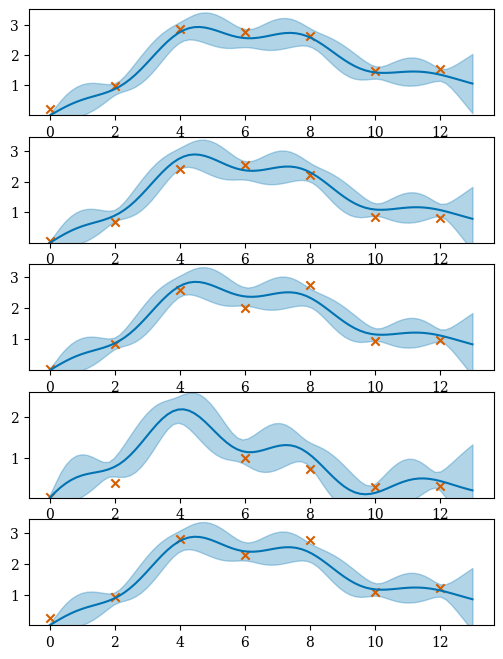

In [387]:
plottter.plot_gp(p_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, labels=False)

MultitaskMultivariateNormal(mean shape: torch.Size([80, 1]))

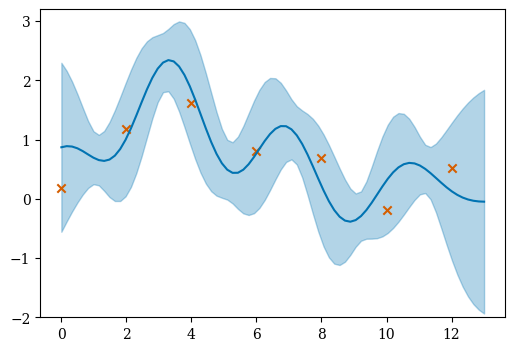

In [388]:
plottter.plot_gp(p_f, t_predict,
                ylim=(-2, 3.2),
                t_scatter=dataset.t_observed, y_scatter=dataset.f_observed, num_samples=0,labels=False)

In [36]:
t_predict = torch.linspace(0, 13, 80, dtype=torch.float64)
p_m = model.predict_m(t_predict, jitter=1e-3)
trained_kxx, trained_kxf, trained_kff, p_f = model.predict_f(t_predict, jitter=1e-3)

new kxf
new kxf
new kxf
new kxf
new kxf
Var shape torch.Size([80, 80])
Var shape torch.Size([1, 80, 80])
Var shape torch.Size([1, 80])
Var shape torch.Size([1, 80, 80])
Var shape torch.Size([1, 80, 80])
Mean shape torch.Size([1, 80])


In [45]:
mean_func = p_f.mean.detach().transpose(0, 1)  # (T, J)
standard_dev = p_f.variance.detach().transpose(0, 1).sqrt()

In [355]:
# Get parameters
params = list(model.named_parameters())
print(params)

[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-1.5084], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[-0.8413]], dtype=torch.float32, requires_grad=True)), ('covar_module.raw_decay', Parameter containing:
tensor([-1.2648, -1.0024, -1.0728,  0.2034, -1.0719], dtype=torch.float32,
       requires_grad=True)), ('covar_module.raw_sensitivity', Parameter containing:
tensor([0.0397, 0.1556, 0.0931, 0.5413, 0.1174], dtype=torch.float32,
       requires_grad=True)), ('mean_module.raw_basal', Parameter containing:
tensor([-2.2622, -3.4819, -2.9798, -3.3692, -2.2567], requires_grad=True))]


In [357]:
# softplus
def sofplus(x):
    return np.log(1 + np.exp(x))

noise = params[0][1].detach().numpy()
lengthscale = params[1][1].detach().numpy()
sensitivity = params[2][1].detach().numpy()
decay = params[3][1].detach().numpy()
basal = params[4][1].detach().numpy()

print(f'Noise: {sofplus(noise)}')
print(f'Lengthscale: {sofplus(lengthscale)}')
print(f'Sensitivity: {sofplus(sensitivity)}')
print(f'Decay: {sofplus(decay)}')
print(f'Basal: {sofplus(basal)}')

Noise: [0.19989111]
Lengthscale: [[0.35847878]]
Sensitivity: [0.24865961 0.3126119  0.29419452 0.79999995 0.2944306 ]
Decay: [0.7131856  0.77397937 0.7407833  0.99999994 0.7535576 ]
Basal: [0.09905283 0.03028527 0.04955397 0.03383758 0.09957239]
